In [39]:
from mirage.reference_files import downloader
download_path = '/Users/beckynevin/CfA_Code/mockIllustris/mirage_files/'
downloader.download_reffiles(download_path, instrument='NIRCam', 
                             dark_type='linearized', skip_darks=False, skip_cosmic_rays=False, 
                             skip_psfs=False, skip_grism=True)



Size of NIRCam cosmic ray library file: 1.1 Gb
Size of NIRCam PSF library file: 23 Gb
Size of NIRCam linearized dark files: 319 Gb
Total size of files to be downloaded: 343.1 Gb
mirage_nircam_cr_library.tar.gz already exists. Skipping download.
nircam_psf_wings_library.tar.gz already exists. Skipping download.
nircam_Amodule_det12_gridded_psf_library.tar.gz already exists. Skipping download.
nircam_Amodule_det345_gridded_psf_library.tar.gz already exists. Skipping download.
Downloading: nircam_Bmodule_det12_gridded_psf_library.tar.gz
Download of nircam_Bmodule_det12_gridded_psf_library.tar.gz complete.
Downloading: nircam_Bmodule_det345_gridded_psf_library.tar.gz
Download of nircam_Bmodule_det345_gridded_psf_library.tar.gz complete.
Linearized_Dark_and_SBRefpix_NRCNRCA1-DARK-60082202011_1_481_SE_2016-01-09T00h03m58_uncal.fits.gz already exists. Skipping download.
Linearized_Dark_and_SBRefpix_NRCNRCA1-DARK-60090213141_1_481_SE_2016-01-09T02h53m12_uncal.fits.gz already exists. Skipping d

KeyboardInterrupt: 

In [1]:

import os
import yaml



In [2]:

from astropy.io import fits
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import numpy as np

In [3]:

from mirage.catalogs.catalog_generator import ExtendedCatalog
from mirage.catalogs.create_catalog import combine_catalogs
from mirage.dark.dark_prep import DarkPrep
from mirage.ramp_generator.obs_generator import Observation
from mirage.imaging_simulator import ImgSim
from mirage.reference_files.downloader import download_file
from mirage.seed_image.fits_seed_image import ImgSeed
from mirage.yaml import yaml_generator

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [4]:

base_url = ('https://data.science.stsci.edu/redirect/JWST/jwst-simulations/'
            'mirage_reference_files/example_data_for_notebooks')

In [5]:
stamp_files = ['3C305.1_stamp.fits', '3C324_stamp.fits', '3C454.1_stamp.fits',
               'hlsp_candels_hst_acs_gs-tot-sect23_f814w_v1.0_drz.fits']

In [6]:
for stamp_file in stamp_files:
    stamp_url = '{}/{}'.format(base_url, stamp_file)
    s_file = download_file(stamp_url, stamp_file, output_directory='./')

Downloading: 3C305.1_stamp.fits
Download of 3C305.1_stamp.fits complete.
Downloading: 3C324_stamp.fits
Download of 3C324_stamp.fits complete.
Downloading: 3C454.1_stamp.fits
Download of 3C454.1_stamp.fits complete.
Downloading: hlsp_candels_hst_acs_gs-tot-sect23_f814w_v1.0_drz.fits
Download of hlsp_candels_hst_acs_gs-tot-sect23_f814w_v1.0_drz.fits complete.


In [32]:
mosaicfile = 'hlsp_candels_hst_acs_gs-tot-sect23_f814w_v1.0_drz.fits'
xml_file = 'mirage_files/mirage-master/examples/imaging_example_data/extended_object_test.xml'
pointing_file = xml_file.replace('.xml', '.pointing')

In [8]:
mosaic = fits.getdata(mosaicfile)
mosaic_header = fits.getheader(mosaicfile)

In [9]:
# Extract a subimage around a star
box = mosaic[3254: 3330, 7071: 7153]
yp, xp = box.shape

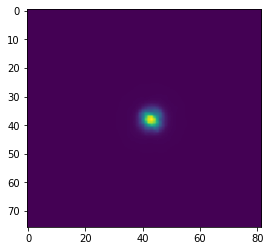

In [10]:
# Look at the extracted box. Make sure the PSF looks reasonable
plt.imshow(box)

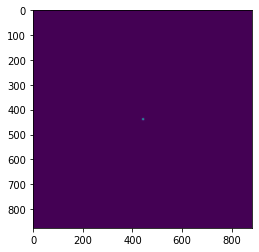

In [17]:
size_interval = 400
plt.imshow(mosaic[3254-size_interval: 3330+size_interval, 7071-size_interval: 7153+size_interval])

In [18]:
# Generate grid of same size as box, to be used in fitting
y, x, = np.mgrid[:yp, :xp]

In [19]:
# Fit the model
p_init = models.Gaussian2D()
fit_p = fitting.LevMarLSQFitter()
fitted_psf = fit_p(p_init, x, y, box)

In [20]:
# Fit results. The FWHM is needed as an input to the
print('Amplitude: ', fitted_psf.amplitude.value)
print('X_mean: ', fitted_psf.x_mean.value)
print('Y_mean: ', fitted_psf.y_mean.value)
print('X_FWHM: ', fitted_psf.x_fwhm)
print('Y_FWHM: ', fitted_psf.y_fwhm)
print('X_stddev: ', fitted_psf.x_stddev.value)
print('Y_stddev: ', fitted_psf.y_stddev.value)

Amplitude:  0.004184192365965793
X_mean:  -1.579213545951955
Y_mean:  -1.1006372656108947
X_FWHM:  7.751973226580422
Y_FWHM:  5.590593600325504
X_stddev:  3.291959928291904
Y_stddev:  2.3741065106535677


In [21]:
measured_mosaic_fwhm = fitted_psf.y_fwhm * (np.abs(mosaic_header['CD2_2']) * 3600.)

In [22]:

# Measured FWHM in arcseconds
measured_mosaic_fwhm

0.16771780130105282

In [23]:
mosaic_fwhm = measured_mosaic_fwhm

In [24]:
cr = {'library': 'SUNMAX', 'scale': 1.0}
dates = '2019-5-25'
background = 'low'
pav3 = 0.0
#catalogs = {'NGC1234': {'nircam': {'point_source': 'ngc1234_ptsrc_nrc.cat',
#                                   'galaxy': 'ngc1234_galaxy_nrc.cat',
#                                   }
#                        }
#            }

In [36]:
#os.environ["MIRAGE_DATA"] = "/Users/beckynevin/CfA_Code/mockIllustris/mirage_files/mirage_data"
yam = yaml_generator.SimInput(xml_file, pointing_file, verbose=True,
                              output_dir='yamls',
                              cosmic_rays=cr,
                              #catalogs=catalogs,
                              background=background, roll_angle=pav3, dates=dates,
                              simdata_output_dir='simdata',
                              datatype='raw')
yam.use_linearized_darks = True
yam.create_inputs()

target_info:
{'MAIN-TARGET': ('03:32:40.0000', '-27:49:0.00')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `Obs 1` uses template `NircamImaging`
APTObservationParams Dictionary holds 0 entries before reading template
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Found 1 tile(s) for observation 001 Obs 1
APTObservationParams Dictionary holds 1 entries after reading template (+1 entries)
Finished reading APT xml file.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of entries before expanding dithers: 1
Number of entries after expanding dithers:  1
Expanded table for Observation 001 has 1 entries

Wrote 1 observations and 1 entries to /Users/beckynevin/CfA_Code/mockIllustris/yamls/observation_list.yaml


In [38]:
filter_keywords = ['FilterWheel', 'ShortFilter', 'LongFilter', 'Filter']
pupil_keywords = ['PupilWheel', 'ShortPupil', 'LongPupil']
print(yam.info)

nrc_sw_optics = set([(f, p) for f, p in zip(yam.info['ShortFilter'], yam.info['ShortPupil'])])
nrc_lw_optics = set([(f, p) for f, p in zip(yam.info['LongFilter'], yam.info['LongPupil'])])
niriss_optics = set([(f, p) for f, p in zip(yam.info['FilterWheel'], yam.info['PupilWheel'])])
niriss_wfss_optics = set([(f, p) for f, p in zip(yam.info['Filter'], yam.info['PupilWheel'])])

print('NIRCam filters/pupils used in this proposal: ')
print(nrc_sw_optics)
print(nrc_lw_optics)
print('\nNIRISS filters/pupils used in this proposal: ')
print(niriss_optics)
print(niriss_wfss_optics)
print(('\nBe sure to add magnitude columns to the template catalog '
        'for all filters you are going to simulate.\n'))

{}


KeyError: 'ShortFilter'

In [ ]:
template_cat = None

In [ ]:

filter1 = 'F150W'
filter2 = 'F444W'

In [ ]:
other_stamp_files = ['3C305.1_stamp.fits', '3C324_stamp.fits', '3C454.1_stamp.fits']
other_stamp_ra = [53.164375, 53.168375, 53.160375]
other_stamp_dec = [-27.815355, -27.811355, -27.819355]
other_stamp_pa = [0., 0., 0.]
other_stamp_f150w_mags = [18., 19., 19.5]
other_stamp_f444w_mags = [22.5, 23.5, 24.0]

# Magnitude values must be strings here because we will be combining them
# with values of 'None' for the resampled image magnitudes
f150w_mags_as_str = [str(element) for element in other_stamp_f150w_mags]
f444w_mags_as_str = [str(element) for element in other_stamp_f444w_mags]

template_extended_catalog_file = 'extended_sources_template.cat'
template_cat = ExtendedCatalog(filenames=other_stamp_files, ra=other_stamp_ra, dec=other_stamp_dec,
                               position_angle=other_stamp_pa)
template_cat.add_magnitude_column(f150w_mags_as_str, instrument='nircam', filter_name=filter1)
template_cat.add_magnitude_column(f444w_mags_as_str, instrument='nircam', filter_name=filter2)
template_cat.save(template_extended_catalog_file)

In [ ]:

yam.yaml_files

In [ ]:
for yfile in [yam.yaml_files[-1]]:
    
    # Read in the yaml file so that we know RA, Dec, PAV3
    # of the exposure
    with open(yfile) as file_obj:
        params = yaml.safe_load(file_obj)
        
    ra = params['Telescope']['ra']
    dec = params['Telescope']['dec']
    pav3 = params['Telescope']['rotation']

    # Define the output files and directories
    sim_data_dir = params['Output']['directory']
    simulated_filename = params['Output']['file']
    crop_file = simulated_filename.replace('.fits', '_cropped_from_mosaic.fits')
    crop_file = os.path.join(sim_data_dir, crop_file)
    blot_file = simulated_filename.replace('.fits', '_blotted_seed_image.fits')
    
    # Crop from the mosaic and resample for the desired detector/aperture
    seed = ImgSeed(paramfile=yfile, mosaic_file=mosaicfile, cropped_file=crop_file,
                   outdir=sim_data_dir, blotted_file=blot_file, mosaic_fwhm=mosaic_fwhm,
                   mosaic_fwhm_units='arcsec', gaussian_psf=False)
    seed.crop_and_blot()

    # Now add the resampled file to the extended source catalog template and
    # save as a separate catalog file
    
    # Need to add a magnitude entry for each filter/pupil
    mosaic_f150w_mag = ['None']
    mosaic_f444w_mag = ['None']
    
    # Create the catalog containing only the resampled image
    blotted_image_full_path = os.path.join(sim_data_dir, blot_file)
    extended_catalog_file = simulated_filename.replace('.fits', '_extended_sources.cat')
    ext_cat = ExtendedCatalog(filenames=[blotted_image_full_path], ra=[ra], dec=[dec], position_angle=[pav3])
    ext_cat.add_magnitude_column(mosaic_f150w_mag, instrument='nircam', filter_name=filter1)
    ext_cat.add_magnitude_column(mosaic_f444w_mag, instrument='nircam', filter_name=filter2)

    # Combine the resampled image catalog and the template catalog
    if template_cat is not None:
        combined_cat = combine_catalogs(ext_cat, template_cat)
        combined_cat.save(extended_catalog_file)
    else:
        ext_cat.save(extended_catalog_file)

    # Now add this extended source catalog to the yaml file
    params['simSignals']['extended'] = extended_catalog_file

    # Save the updated yaml file
    with open(yfile, 'w') as file_obj:
        dump = yaml.dump(params, default_flow_style=False)
        file_obj.write(dump)

In [ ]:
for yfile in [yam.yaml_files[-1]]:
    sim = ImgSim(paramfile=yfile)
    sim.create()


In [ ]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max), origin='lower')
    plt.title(title)
    plt.colorbar().set_label('DN$^{-}$/s')

In [ ]:
# Look at the noiseless seed image
show(sim.seedimage,'Seed Image', max=0.4)

In [ ]:
show(sim.seedimage[700: 1300, 700: 1300],'Seed Image', max=0.6)

In [ ]:
from mirage.imaging_simulator import ImgSim
import os
os.environ["MIRAGE_DATA"] = "/Users/beckynevin/CfA_Code/mockIllustris/mirage_files"
#export MIRAGE_DATA="/Users/beckynevin/CfA_Code/mockIllustris/mirage_files"

sim = ImgSim(paramfile='my_yaml_file.yaml')
sim.create()